In [131]:
#import libraries
import pandas as pd
import numpy as np
from scipy import stats
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
# import the metrics class
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [682]:
df = pd.read_csv("C:/Users/peta/Desktop/Physics/final3.csv")

In [683]:
df.head()

,teacher_id,plan,paid,state,num_student,age_days,log_first_month,log_last_month,num_device,num_browser,...,month_total_problems_1,month_total_problems_2,month_total_problems_3,month_total_problems_updated_1,month_total_problems_updated_2,month_total_problems_updated_3,t1_r_1,t1_r_2,t1_r_3,high_income_state
0,78,1,1,Arizona,20,245.0,2019-07,2020-03,2,2,...,332.0,123.0,48.0,664.0,123.0,48.0,0.971367,1.00,1.00,0
1,83,0,0,Kentucky,0,0.0,2019-07,2019-07,1,1,...,178.0,0.0,0.0,356.0,0.0,0.0,1.000000,0.98,0.98,0
2,85,3,1,Washington,6,250.0,2019-07,2020-04,2,2,...,200.0,0.0,0.0,400.0,0.0,0.0,0.904050,0.98,0.98,1
3,87,0,0,South Dakota,0,40.0,2019-07,2019-09,1,2,...,197.0,0.0,0.0,394.0,0.0,0.0,1.000000,0.98,0.98,0
4,88,0,0,Ohio,0,0.0,2019-07,2019-07,1,1,...,178.0,0.0,0.0,356.0,0.0,0.0,1.000000,0.98,0.98,0


# 1. Eploratory Data Analysis 

## 1.1. Define churn and narrow down to a specific cohort for the analysis 

In [823]:
df1 = pd.read_csv("C:/Users/peta/Desktop/Physics/final3.csv")

# define churn age_days<=30 
df1.loc[df1['age_days']<=30, 'churn'] = 1
df1.loc[df1['age_days']>30, 'churn'] = 0

# focus the research to fall 2019 cohort
df = df1.loc[df1['log_first_month']< '2020-01']


In [824]:
# churn rate
churn_1_day_rate = (df.loc[df['age_days']==0]['teacher_id'].nunique())/df['teacher_id'].nunique()
churn_30_day_rate = (df.loc[df['age_days']<=30]['teacher_id'].nunique())/df['teacher_id'].nunique()
churn_60_day_rate = (df.loc[df['age_days']<=60]['teacher_id'].nunique())/df['teacher_id'].nunique()
churn_90_day_rate = (df.loc[df['age_days']<=90]['teacher_id'].nunique())/df['teacher_id'].nunique()
print ('First Day Churn Rate: ', churn_1_day_rate)
print ('First 30 Days Churn Rate: ', churn_30_day_rate)
print ('First 60 Days Churn Rate: ', churn_60_day_rate)
print ('First 90 Days Churn Rate: ', churn_90_day_rate)

First Day Churn Rate:  0.6733601070950469
First 30 Days Churn Rate:  0.7282463186077643
First 60 Days Churn Rate:  0.7523427041499331
First 90 Days Churn Rate:  0.7630522088353414


In [825]:
df['score_improve_1'].describe()
# fill missing value for score_improve_1
df['score_improve_1'] = df['score_improve_1'].fillna(1)

## 1.2. Visulization
### Prepare features

In [826]:
# rename the features to make them self-exploratory
df = df.rename(columns ={
        'month_total_problems_updated_1': 'num_problem_student',
        'total_practice_month_udpated_teacher_1': 'num_problem_teacher',
        'month_log_days_1':'log_days_monthly',  
        'month_log_times_day_1':'log_freq_daily',
        'score_improve_1':'improvement',
        't1_r_1':'ratio_work_session' 
})

# as I will predict 30 days churn, I will only use those features for the first 30 days
features = ['plan', 
            'high_income_state',
            'paid_verified',
            'log_first_month',
            'num_student', 
            'num_device', 
            'num_browser',
            'num_problem_teacher',
            'num_problem_student',
            'log_days_monthly', 
            'log_freq_daily',
            'improvement',
            'ratio_work_session' ]
# I combine features into two lists so that we can analyze them jointly
categorical_features = ['plan', 
            'high_income_state',
            'paid_verified',
            'log_first_month' ]
numerical_features = ['num_student', 
            'num_device', 
            'num_browser',
            'num_problem_teacher',
            'num_problem_student',
            'log_days_monthly', 
            'log_freq_daily',
            'improvement',
            'ratio_work_session']
target = 'churn'

### Check numeric data distribution
First, let's start with numeric summarizing to generate a basic idea about the dataset.

In [827]:
df[numerical_features].describe()

,num_student,num_device,num_browser,num_problem_teacher,num_problem_student,log_days_monthly,log_freq_daily,improvement,ratio_work_session
count,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,9.819277,1.107095,1.109772,12.617387,110.331995,2.370817,1.327822,1.003943,0.980376
std,28.679205,0.309441,0.360590,55.527163,155.514056,3.281402,0.739592,0.052365,0.073786
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.091304,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.980000
50%,0.000000,1.000000,1.000000,0.000000,42.000000,1.000000,1.000000,1.000000,1.000000
75%,0.500000,1.000000,1.000000,0.000000,125.000000,1.833333,1.222222,1.000000,1.000000
max,276.000000,2.000000,4.000000,753.647059,998.000000,30.000000,8.000000,1.567954,1.000000


### Outlier imputation


In [828]:
# score improve < 0.7 is likely to be outlier, replacd with na
df.loc[df['improvement']<0.7, 'improvement'] = 0.7
# t1_r_1 <0.7 is likely to be outlier, replace with na
df.loc[df['ratio_work_session']<0.7, 'ratio_work_session'] = 0.7

### check the distribution by group

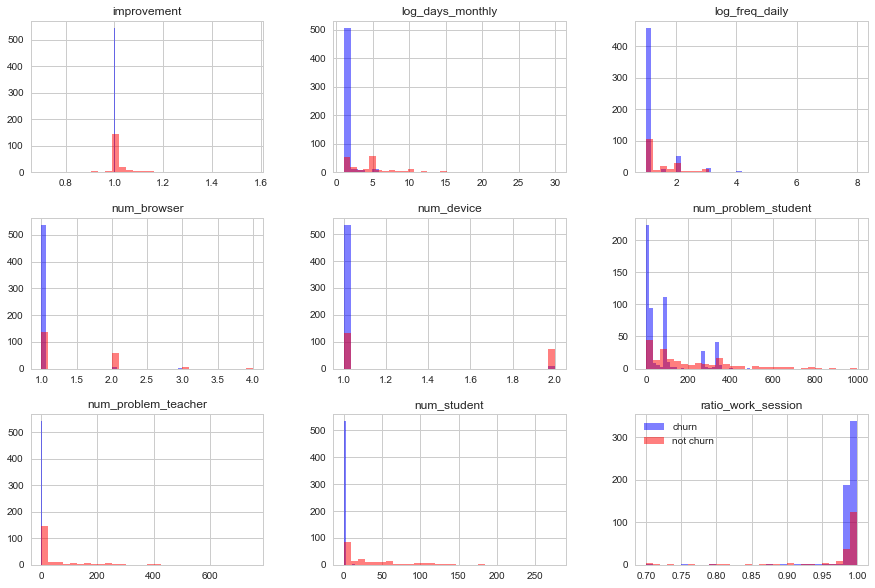

In [829]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
df[df.churn == 1][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.churn == 0][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)
plt.legend(['churn', 'not churn'])

### Update features after checking the distribution by replacing outliers

In [830]:
# log_freq_daily is converted to suffer login problem
df.loc[df['log_freq_daily']> 3, 'login_problem'] = 1 
df.loc[df['log_freq_daily']<=3, 'login_problem'] = 0
# num of students is  converted to categorical variables: 0, 1-50, 50+
df.loc[df['num_student']==0, 'class_size'] = 'No_Student'
df.loc[(df['num_student']>0) & (df['num_student']<=30), 'class_size'] = 'Regular'
df.loc[df['num_student']>30, 'class_size'] = 'Large'


* Update features

In [831]:
# as I will predict 30 days churn, I will only use those features for the first 30 days
# I combine features into two lists so that we can analyze them jointly
# as I will predict 30 days churn, I will only use those features for the first 30 days
features = ['plan', 
            'high_income_state',
            'paid_verified',
            'log_first_month',
            'login_problem',
            'class_size'
            'num_student', 
            'num_device', 
            'num_browser',
            'num_problem_teacher',
            'num_problem_student',
            'log_days_monthly', 
            'log_freq_daily',
            'improvement',
            'ratio_work_session' ]
# I combine features into two lists so that we can analyze them jointly
categorical_features = ['plan', 
            'high_income_state',
            'paid_verified',
            'log_first_month',
            'login_problem',
            'class_size']
numerical_features = ['num_student', 
            'num_device', 
            'num_browser',
            'num_problem_teacher',
            'num_problem_student',
            'log_days_monthly', 
            'log_freq_daily',
            'improvement',
            'ratio_work_session']
target = 'churn'

### Numerical features distribution by Group

***
The distributions of numerical features show that there are difference patterns for churn and retained users 
***

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E840EC4B70>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001E842771BE0>], dtype=object)

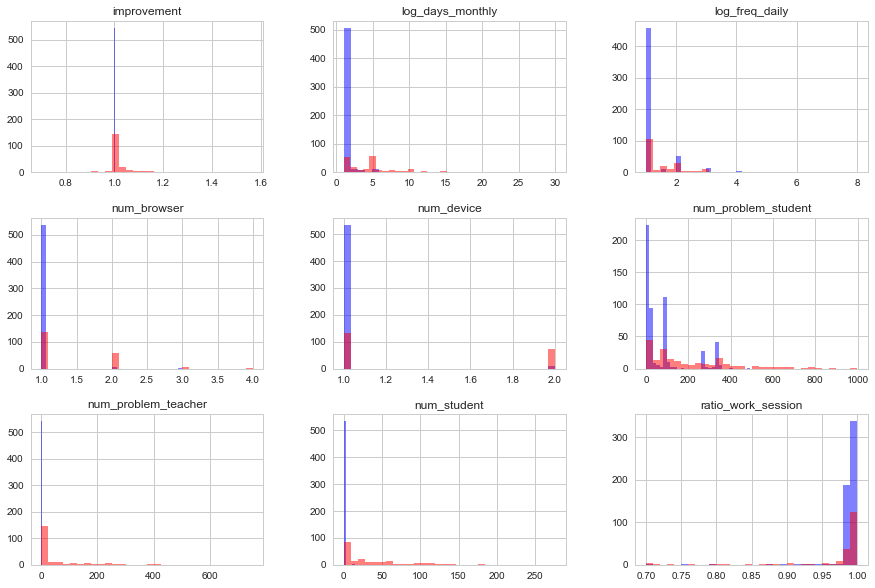

In [832]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
df[df.churn == 1][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.churn == 0][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)


### Categorical feature distribution
To analyze categorical features, I use bar charts. 

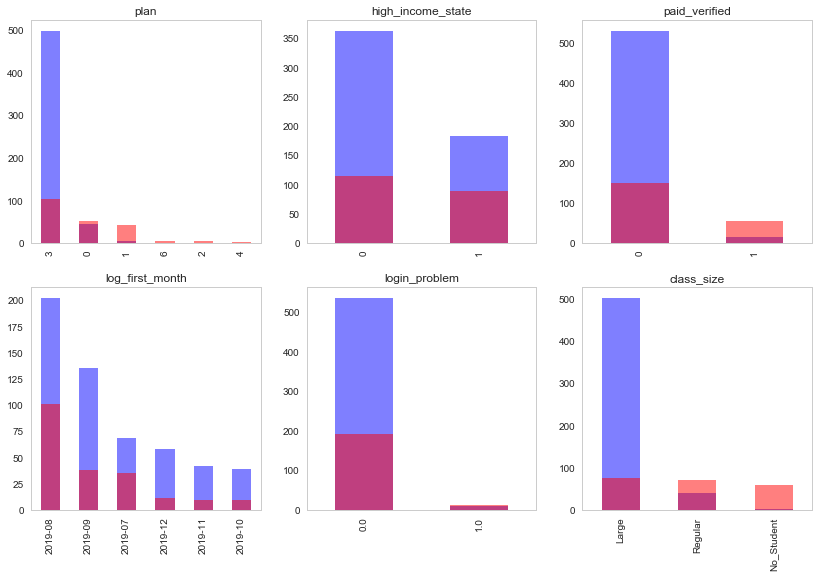

In [833]:
ROWS, COLS = 2, 3
fig, ax = plt.subplots(ROWS, COLS, figsize=(14, 9))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[df.churn == 1][categorical_feature].value_counts().plot('bar', ax=ax[row, col], color="blue", alpha=0.5, fontsize = 10).\
    set_title(categorical_feature, fontsize = 12)
    df[df.churn == 0][categorical_feature].value_counts().plot('bar', ax=ax[row, col], color="red", alpha=0.5, fontsize = 10).\
    set_title(categorical_feature, fontsize = 12)


### Target variable pie chart
Churn probability 

(-1.1186136069320769,
 1.1115037906132557,
 -1.114632274166433,
 1.1006967749603063)

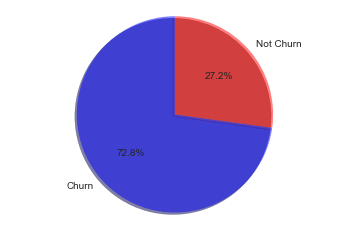

In [834]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Churn', 'Not Churn'
colors = ['blue', 'red']

fig1, ax1 = plt.subplots()
ax1.pie(df[target].value_counts(),  labels=labels, colors =colors ,  autopct='%1.1f%%',wedgeprops={'alpha':0.5},
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

Text(0.5,1,'Days Bettwen Teachers First and Last Login')

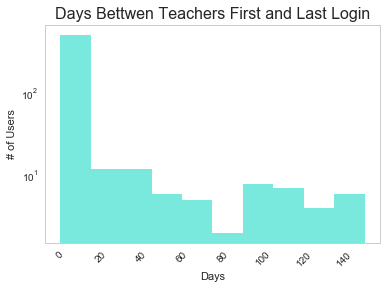

In [835]:
plt.hist(df.loc[df['age_days']<=150, 'age_days'], bins = 10, alpha = 0.7,  color = 'turquoise', log = True)
plt.grid(False)
plt.xticks(rotation=45)
plt.xlabel('Days')
plt.ylabel('# of Users')
plt.title('Days Bettwen Teachers First and Last Login', fontsize=16)
#sns.distplot(df['age_days'], kde = False)

Text(0.5,1,'Days Bettwen Teachers First and Last Login')

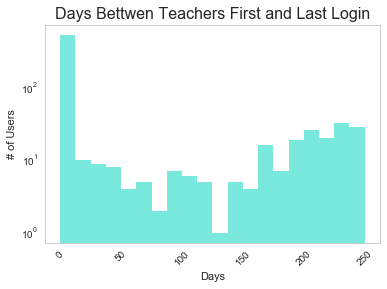

In [836]:
plt.hist(df[ 'age_days'], bins = 20, alpha = 0.7,  color = 'turquoise', log = True)
plt.grid(False)
plt.xticks(rotation=45)
plt.xlabel('Days')
plt.ylabel('# of Users')
plt.title('Days Bettwen Teachers First and Last Login', fontsize=16)

#sns.distplot(df['age_days'], kde = False)

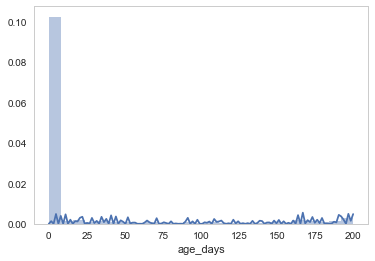

In [837]:
sns.distplot(df.loc[df['age_days']<=200, 'age_days'])

Text(0.5,1,'Users Registration by Month')

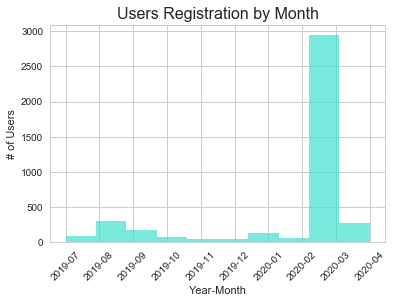

In [838]:
plt.hist(df1['log_first_month'], bins = 10, alpha = 0.7,  color = 'turquoise')
plt.grid(b=None)
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('# of Users')
plt.title('Users Registration by Month', fontsize=16)
#sns.distplot(df['age_days'], kde = False)

###  Generate categorical features

In [839]:
#  Decode categorical features
df = pd.get_dummies(df, columns = ['log_first_month', 
                                   'plan',
                                   'class_size'])


In [840]:
# update features
categorical_features = [
            'high_income_state',
            'paid_verified',
            'login_problem',#'log_freq_daily'
            'plan_0', 'plan_1', 'plan_2', 'plan_3', 'plan_4', 'plan_6',
             'log_first_month_2019-07', 'log_first_month_2019-08',
            'log_first_month_2019-09', 'log_first_month_2019-10',
            'log_first_month_2019-11', 'log_first_month_2019-12', 
            'class_size_Large', 'class_size_No_Student','class_size_Regular' # 'num_student'
            ]
numerical_features = ['num_student', 
            'num_device', 
            'num_browser',
            'num_problem_teacher',
            'num_problem_student',
            'log_days_monthly', 
            'log_freq_daily',
            'improvement',
            'ratio_work_session']

target = 'churn'
features = [
            'high_income_state',
            'paid_verified',
            'login_problem',#'log_freq_daily'
            'plan_0', 'plan_1', 'plan_2', 'plan_3', 'plan_4', 'plan_6',
             'log_first_month_2019-07', 'log_first_month_2019-08',
            'log_first_month_2019-09', 'log_first_month_2019-10',
            'log_first_month_2019-11', 'log_first_month_2019-12', 
            'class_size_Large', 'class_size_No_Student','class_size_Regular', # 'num_student'
            'num_student', 
            'num_device', 
            'num_browser',
            'num_problem_teacher',
            'num_problem_student',
            'log_days_monthly', 
            'log_freq_daily',
            'improvement',
            'ratio_work_session']

### Correlation check

In [841]:
num = df[numerical_features].corr()
cat = df[categorical_features].corr()

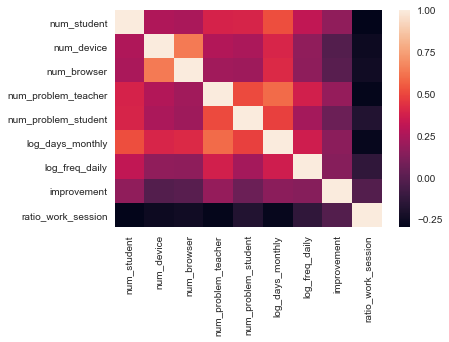

In [842]:
sns.heatmap(num)

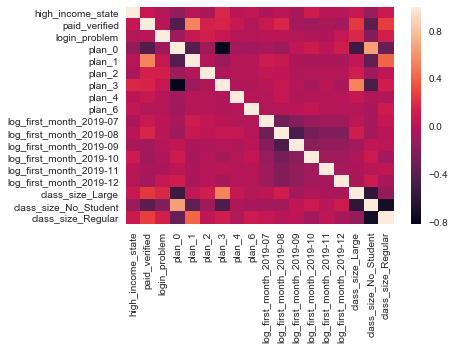

In [843]:
sns.heatmap(cat)

# 3. Modeling


# get model run!


Target variable distribution shows that we are dealing with an imbalanced problem as there are many more churned users. The model would achieve high accuracy as it would mostly predict majority class — users who did churn in my example.
Few things I can do to minimize the influence of imbalanced dataset:
- resample data (imbalanced-learn),
- collect more samples,
- use precision and recall as accuracy metrics.


In [844]:
dataframe = df

### Rescale features

In [845]:
from sklearn import preprocessing

x = features
y = target
# rescale
df[x] = preprocessing.scale(df[x])


### Downsampling 

In [846]:

from sklearn.utils import resample
# Separate majority and minotiry classes
df_majority = df[df.churn == 1]
df_minority = df[df.churn == 0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=203,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.churn.value_counts()

0.0    203
1.0    203
Name: churn, dtype: int64

### Features selection with domain knowlege, correlation check, and L1. 

In [854]:
# update the features after feature selection with domain knowlege, correlation check, and L1. 

features = [
            'high_income_state',
            'paid_verified',
             'log_first_month_2019-07', 'log_first_month_2019-08',
            'log_first_month_2019-09', 'log_first_month_2019-10',
            'log_first_month_2019-11', 
            'num_student', 
            'num_device', 
            'num_problem_teacher',
            'num_problem_student',
            'log_days_monthly', 
            'log_freq_daily',
            'improvement',
            'ratio_work_session']

In [855]:
# split sample
x = features
y = target
X_train,X_test,y_train,y_test=train_test_split(df_downsampled[x],df_downsampled[y],test_size=0.25,random_state=2)

### Fit Logistic Regression

In [856]:
# Fit logistic regression
#logreg = LogisticRegression()
logreg = LogisticRegression(penalty='l1', C = 10, solver='liblinear')
# fit the model with data
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)


Accuracy of logistic regression classifier on test set: 0.83


### Feature Selection with L1



In [857]:
from sklearn.feature_selection import SelectFromModel
# L1 Selected features
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1', C = 0.5, solver='liblinear')).fit(X_train, y_train)
selector.get_support()

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False,  True], dtype=bool)

In [858]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
    """
    This function prints and plots the normalized confusion matrix.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print ('Confustion Matrix without Normalization')
    print (cm)
    # Normalize confustion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # plot the confusion matrix 
    fig, ax = plt.subplots()
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest',  cmap="YlGnBu" )
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes,
           title='Normalized confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confustion Matrix without Normalization
[[40 14]
 [ 3 45]]


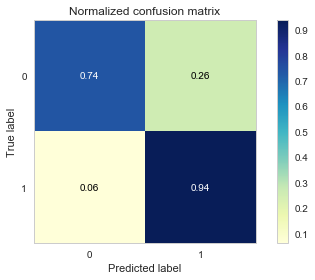

In [859]:
plot_confusion_matrix(y_test, y_pred)

In [860]:
#L1
logit_model=sm.Logit(df_downsampled[y],df_downsampled[x])
#result=logit_model.fit()
result = logit_model.fit()
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.349611
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                  406
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                           14
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  0.4956
Time:                        19:17:49   Log-Likelihood:                -141.94
converged:                       True   LL-Null:                       -281.42
                                        LLR p-value:                 2.852e-51
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
high_income_state          -0.1912      0.151     -1.266      0.206      -0.487   

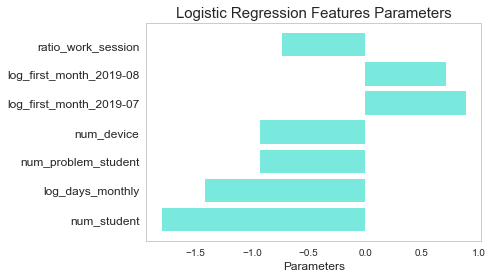

In [876]:
### Visualize the importance of features
label = ['num_student',
        'log_days_monthly',
        'num_problem_student',
        'num_device',
        'log_first_month_2019-07',
        'log_first_month_2019-08',
        'ratio_work_session'        ]
par = [-1.7982,  -1.4171, -0.9275, -0.9296 ,   0.8892, 0.7111, -0.7384 ]
#index = np.arange(len(label))
plt.rcParams["axes.grid"] = False
def plot_bar_x(x, y, z):
    # this is for plotting purpose
    index = np.arange(len(x))
    plt.barh(index, y, alpha =0.7, color = 'turquoise')
    plt.xlabel('Parameters', fontsize=12)
    plt.yticks(index, x, fontsize=12)
    plt.title(z, fontsize = 15)
    plt.show()
plot_bar_x(label, par, 'Logistic Regression Features Parameters')

In [862]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.833333333333
Precision: 0.762711864407
Recall: 0.9375


In [863]:
# Report the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.93      0.74      0.82        54
        1.0       0.76      0.94      0.84        48

avg / total       0.85      0.83      0.83       102



### Fit Random Forest Model

In [870]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=500, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [871]:
# Actual class predictions
rf_predictions = model.predict(X_test_scaled)
print(classification_report(y_test, rf_predictions))

             precision    recall  f1-score   support

        0.0       0.63      0.83      0.72        54
        1.0       0.71      0.46      0.56        48

avg / total       0.67      0.66      0.64       102



### Feature Importance

In [867]:
import pandas as pd

# Extract feature importances
fi = pd.DataFrame({'feature': list(df[x].columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(10)

,feature,importance
11,log_days_monthly,0.380421
7,num_student,0.183079
10,num_problem_student,0.105683
8,num_device,0.094530
12,log_freq_daily,0.056354
9,num_problem_teacher,0.040838
1,paid_verified,0.030500
14,ratio_work_session,0.026267
13,improvement,0.023237
0,high_income_state,0.018100


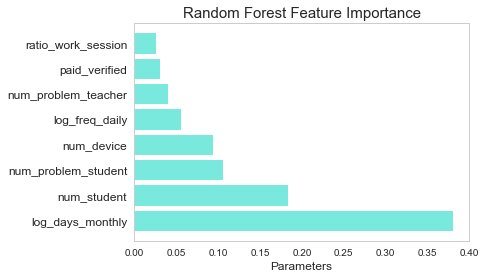

In [868]:
feature = ['log_days_monthly', 'num_student', 'num_problem_student', 'num_device', 'log_freq_daily', 'num_problem_teacher', 'paid_verified', 'ratio_work_session']

par = [0.380421,0.183079, 0.105683, 0.094530, 0.056354, 0.040838, 0.030500, 0.026267 ]

plot_bar_x(feature, par, 'Random Forest Feature Importance')
#fi.iloc[:,0].tolist()

Confustion Matrix without Normalization
[[45  9]
 [26 22]]


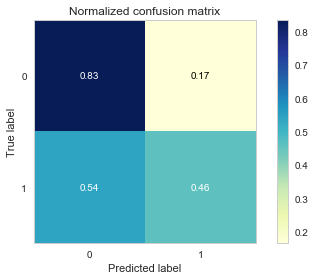

In [872]:
plot_confusion_matrix(y_test,rf_predictions)

In [869]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_predictions))

             precision    recall  f1-score   support

        0.0       0.63      0.83      0.72        54
        1.0       0.71      0.46      0.56        48

avg / total       0.67      0.66      0.64       102

